# Modelo de Pairs Trading Baseado em Cointegração

**Autores: Alexandre Fernandes Theoharidis, Débora Darin e Nelly Pires Colnaghi**

**Este trabalho contém:**

**1)** Importação da série de preços das ações PETR3 e PETR4 e tratamento de dados **(apresentado no notebook parte 1)**;

**2)** Cálculo da regressão linear dos preços das ações & computação dos resíduos da regressão (spreads) para verificação de desvios da média **(apresentado no notebook parte 1)**;

**3)** Backtest da estratégia de pairs trading;

**4)** Cálculo do retorno para o par PETR3 x PETR4.

## Bibliotecas

Abaixo estão todas as bibliotecas utilizadas no código.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações

As configurações necessárias às bibliotecas empregadas no modelo estão consolidadas abaixo.

In [2]:
# Comando para que os gráficos sejam exibidos no corpo do texto
%matplotlib inline

In [3]:
plt.rcParams['figure.dpi'] = 200 # Resolução dos gráficos impressos no pdf (dpi)

In [4]:
# Estilo dos gráficos
sns.set(color_codes = True)

## Parâmetros

Esses são os parâmetros referentes aos modelos de pairs trading que são implementados no código, a serem detalhados mais a frente.

In [5]:
alfa = 0.01 # Nível de significância utilizado nos testes de hipótese 
janela_dados = 252 # tamanho da janela de dados utilizada para estimação dos modelos
janela_coint = 5 # janela de dias que será analisada para determinação da cointegração das ações de um par
cost = 0 # custo de execução 
th_KF = 0.25 # Número de desvios-padrão de distância da média para abertura de posição usando KF
delta_beta_lim = 0 #variável para reduzir a frequência de ajustes de posição

## Importação e Tratamento dos Dados

In [6]:
# Leitura da planilha com as séries de preços diários das ações de cada par

str_dir = 'D:/Estudos/2 Mestrado/Insper/Disciplinas/Finanças Quantitativas/Projeto/'
str_plan_bd_stocks = 'BD_Stocks_v4'

df_prices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_bd_stocks + '.csv', sep=';')
df_prices.index = df_prices['Dates']
df_prices.index = pd.to_datetime(df_prices['Dates'])
df_prices = df_prices.drop(columns=['Dates'])
df_prices = df_prices.dropna()

In [7]:
# Log preços - serão usados nos testes de cointegração
df_log_prices = np.log(df_prices)
df_log_prices.head()

,PETR3 BZ Equity,PETR4 BZ Equity
Dates,,
2008-01-02,3.954220,3.772761
2008-01-03,3.939638,3.756538
2008-01-04,3.878466,3.706228
2008-01-07,3.843530,3.676427
2008-01-08,3.901973,3.729901


In [8]:
s_KF = pd.read_csv(filepath_or_buffer = str_dir + 's_KF.csv', sep=',')
s_KF.index = s_KF['Dates']
s_KF.index = pd.to_datetime(s_KF['Dates'])
s_KF = s_KF.drop(columns=['Dates'])
s_KF = s_KF.dropna()
s_KF.head()

,Spread
Dates,
2008-01-02,0.000000
2008-01-03,0.000532
2008-01-04,-0.003338
2008-01-07,-0.002724
2008-01-08,0.000706


In [9]:
adf_KF = pd.read_csv(filepath_or_buffer = str_dir + 'adf_KF.csv', sep=',')
adf_KF = adf_KF.drop(columns = adf_KF.columns[0])
adf_KF.index = s_KF.index
adf_KF.head()

,ADF
Dates,
2008-01-02,NaN
2008-01-03,NaN
2008-01-04,NaN
2008-01-07,NaN
2008-01-08,NaN


In [10]:
beta_KF = pd.read_csv(filepath_or_buffer = str_dir + 'beta_KF.csv', sep=',')
beta_KF = beta_KF.drop(columns = beta_KF.columns[0])
beta_KF.index = s_KF.index
beta_KF.head()

,Beta1
Dates,
2008-01-02,1.000000
2008-01-03,0.999973
2008-01-04,1.000604
2008-01-07,1.001232
2008-01-08,1.001207


## Backtest

O objetivo dessa seção é efetuar um backtest da estratégia de pairs trading para verificação de seu retorno no período analisado. Para realização do backtest da estratégia, utilizaremos de um modelo de Thresholds com método de estimação via Filtro de Kalman (backtest_KF), que permite estimação diária dos coeficientes da regressão. 

Como preocupação para **não se utilizar de dados futuros** para a decisão de trading e cálculo dos retornos, foram **deslocados um dia para trás**:

**1.** A série de spread, que atua como sinal;

**2.** Os betas;

**3.** Os resultados dos testes de cointegração.

Tal regra pode ser observada nos índices dos dateframes que são percorridos nos loops - **ex:** fim_est-1 e fim_est-janela_coint-1.

 ### Função para Realização do Backtest Usando Filtro de Kalman e Threshold Predeterminados

#### Função que informa em que intervalo do spread se encontra

A função retorna a posição onde o spread se localiza, podendo retornar ao limite superior de cima, limite superior entre as bandas, limite inferior entre as banda e limite inferior de baixo.

Importante ressaltar que os resultados iniciais correspondentes a primeira janela móvel não são relevantes, pois, na função de backtest, onde os resultados serão utilizados, essa primeira janela não é levada em consideração, visto que o trade só começa após a mesma.

In [11]:
## A função retorna a posição onde o spread se localiza
## Limite superior de cima: resultado = 3
## Limite superior entre as bandas: resultado = 2
## Limite inferior entre as banda: resultado = 1
### Limite inferior de baixo: resultado = 0

def intervalos(df_spread, janela_dados, th):
    
    avg_spread = df_spread.rolling(window = janela_dados).mean()
    vol_spread = df_spread.rolling(window = janela_dados).std(ddof = 1)
                        
    lim_sup = avg_spread + th*vol_spread
    lim_inf = avg_spread - th*vol_spread
    
    resultado = (df_spread > lim_sup)*1 + (df_spread > avg_spread)*1 + (df_spread > lim_inf)*1

    return resultado

#### Função do Backtest

In [12]:
def backtest_KF(log_price1, log_price2, df_spread, df_interv, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 2 # começa 2 para frente pois iremos aplicar um shift de 2 dias
    fim_est = janela_dados + 2 # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # 1 se o par foi aberto quando o spread estava na região superior de fora
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-2,0]
    beta1 = df_beta1.iloc[fim_est-2,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1 - 1) - (fim_est - janela_coint - 1) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint-1, fim_est-1), 0]) == True:
            
            # Acompanha a variação do beta de um dia para o outro para ajustar a posição de acordo
            # com a variação do beta
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-2,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-2,0]
               
            # Caso 1: spread na parte superior de fora da banda
            if df_interv.iloc[fim_est-2,0] == 3:
                    
                # Caso 1.1: sem posição em aberto --> abre posição
                if par_aberto == False:
                    
                    beta1 = df_beta1.iloc[fim_est-2,0]
                    par_aberto = True
                    pos_aberto = 1
                    
                # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                    
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                    
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
    
            # Caso 2: spread na parte superior de dentro da banda
            if df_interv.iloc[fim_est-2,0] == 2:
                
                # Caso 2.1: sem posição em aberto --> mantém
                if par_aberto == False:
                        
                    par_aberto = False
                    
                # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                        
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                
            # Caso 3: spread na parte inferior de dentro da banda
            if df_interv.iloc[fim_est-2,0] == 1:
                    
                # Caso 3.1: sem posição em aberto --> mantém
                if par_aberto == False:
                        
                    par_aberto = False
                    
                # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                if par_aberto == True and pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                    
                # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                if par_aberto == True and pos_aberto == -1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
            # Caso 4: spread na parte inferior de fora da banda
            if df_interv.iloc[fim_est-2,0] == 0:
        
                # Caso 4.1: sem posição em aberto --> abre
                if par_aberto == False:
                        
                    beta1 = df_beta1.iloc[fim_est-2,0]
                    par_aberto = True
                    pos_aberto = -1
                    
                # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                if par_aberto == True and pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                    
                # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                if par_aberto == True and pos_aberto == -1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2 
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

## Exemplo de Pair Trading - PETR3 x PETR4

Nessa sessão realizamos um exemplo de implementação da estratégia de pairs trading com cointegração, utilizando os spreads calculados pelo filtro de Kalman e adotando um modelo de thresholds para regrar a negociação do par. Para esta análise foi utilizado o par de ações PETR3 e PETR4, papéis da mesma empresa e que possuem alta correlação entre si. Ao final, também foi construído um gráfico de retornos acumulados da estratégia para ilustrar o desempenho desta.

In [15]:
# Cálculo do retorno acumulado para as séries de preço
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0 #Para casos de não intercepto na regressão do filtro de Kalman, as séries de preço são normalizadas começando em zero
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0 #Para casos de não intercepto na regressão do filtro de Kalman, as séries de preço são normalizadas começando em zero
y = y.cumsum()

In [16]:
interv_KF = intervalos(s_KF, janela_dados, th_KF)

#### Implementação da Função de Backtest

In [17]:
df_log_retornos_KF_th = backtest_KF(y, x, s_KF, interv_KF, beta_KF, adf_KF, 
                                    janela_dados, janela_coint, cost, delta_beta_lim)

#### Gráfico dos Retornos Acumulados da Estratégia

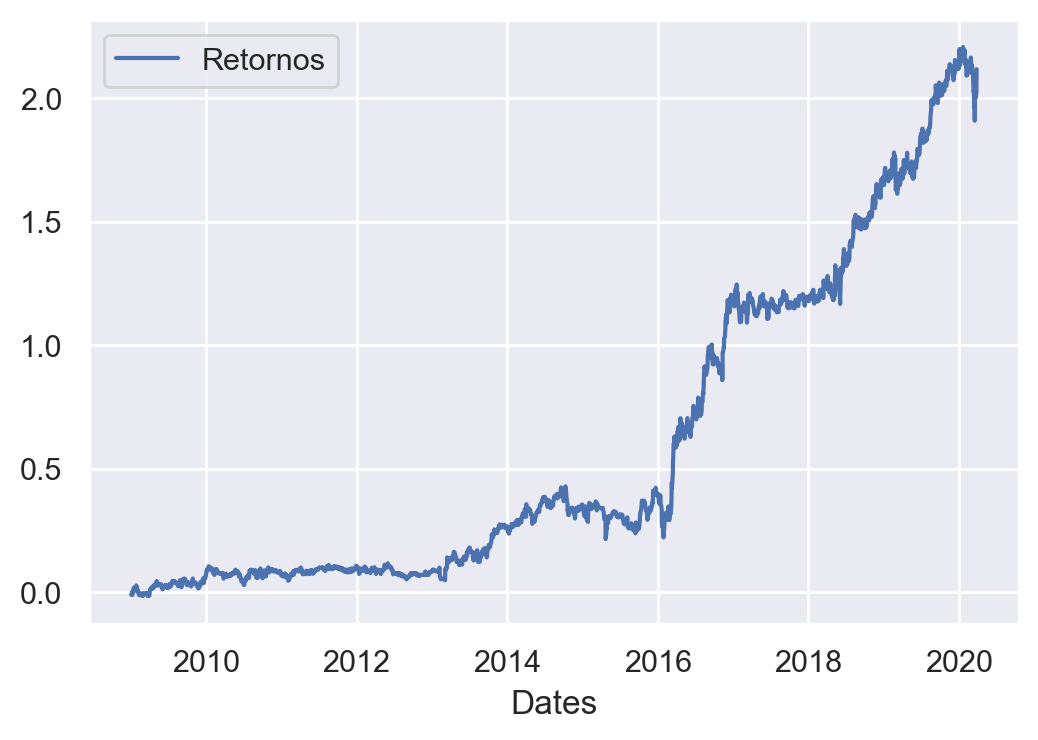

In [18]:
sns.lineplot(data=np.exp(df_log_retornos_KF_th.cumsum())-1)

## Referências Bibliográficas

CALDEIRA, J. F.; MOURA, G. V. Selection of a portfolio of pairs based in cointegration: A statistical arbitrage strategy. Revista Brasileira de Finanças, v. 11, n. 1, p. 49-80, mar. 2013.

CARHART, M. M., On persistence in mutual fund performance. Journal of Finance, v. 52, n. 1, p. 57-82, mar. 1997.

FAMA, E. F., FRENCH, K. F., Common risk factors in the returns on stocks and bonds. Journal of Financial Economics, v.33, n.1, p. 3-56, fev. 1993.

GATEV, E., $et.$ $al$. Pairs trading: performance of a relative-value arbitrage rule. Review of Financial Studies, v. 19, n. 3, p. 797-827, mar. 2006.